In [ ]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt

# --- Parametri ---
c = 1.0          # velocità
L = 2.0          # lunghezza dominio
nx = 500         # numero intervalli
T = 1            # tempo finale
dt = 0.001       # passo temporale
nt = int(T / dt) + 1
t_vals = np.linspace(0., T, nt)
plot_times = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]


# --- Mesh e spazio ---
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
V = fem.functionspace(domain, ("Lagrange", 1))

# --- Condizioni al contorno Dirichlet u=0 ---
u_bc = fem.Function(V)
u_bc.x.array[:] = 0.0
facets = mesh.locate_entities_boundary(
    domain, dim=0,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
)
dofs = fem.locate_dofs_topological(V, entity_dim=0, entities=facets)
bc = fem.dirichletbc(u_bc, dofs)

# --- Funzioni temporali ---
u0 = fem.Function(V)  # u^{n-1}
u1 = fem.Function(V)  # u^{n}
u_new = fem.Function(V)  # u^{n+1}

# --- Inizializzazione ---
x_coords = V.tabulate_dof_coordinates()[:, 0]
u1.x.array[:] = gaussian(x_coords)
u0.x.array[:] = u1.x.array  # velocità iniziale = 0

# --- Variabili per forma debole ---
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# --- Matrice A (costante) ---
a_form = (u * v / dt**2) * ufl.dx + c**2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = fem.petsc.assemble_matrix(fem.form(a_form), bcs=[bc])
A.assemble()

solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType("preonly")
solver.getPC().setType("lu")

# --- Loop temporale ---
for t_current in t_vals:

    # Grafico nei tempi richiesti
    if np.any(np.isclose(t_current, plot_times, atol=dt / 2)):
        plt.plot(x_coords, u1.x.array, label=f"t={t_current:.2f}")

    # Salta il passo temporale 0
    if np.isclose(t_current, T):
        break

    # --- Termine destro b ---
    L_form = (2.0 * u1 * v / dt**2 - u0 * v / dt**2) * ufl.dx
    b = fem.petsc.assemble_vector(fem.form(L_form))
    fem.petsc.apply_lifting(b, [fem.form(a_form)], bcs=[[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # --- Risoluzione per u_new ---
    solver.solve(b, u_new.x.petsc_vec)
    u_new.x.scatter_forward()

    # --- Aggiornamento per passo successivo ---
    u0.x.array[:] = u1.x.array
    u1.x.array[:] = u_new.x.array

# --- Plot finale ---
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.show()


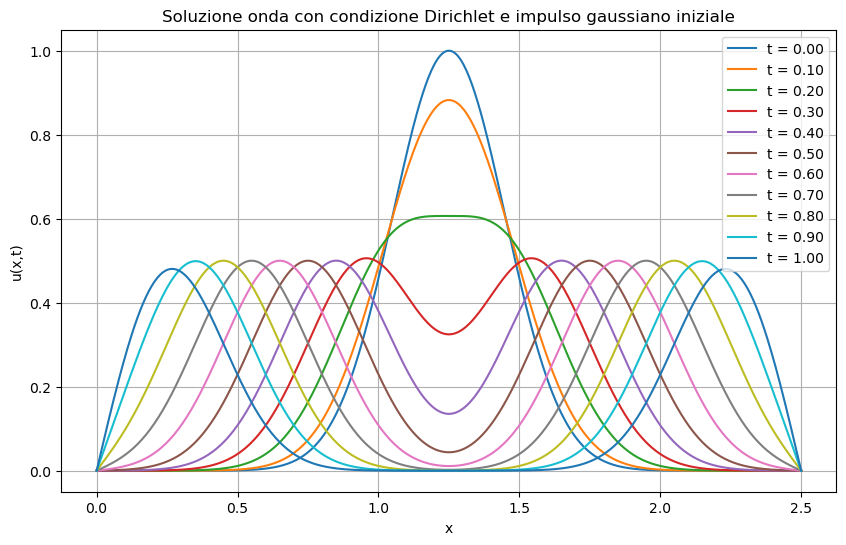

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
L = 2.5
c = 1.0
N_modes = 50
nx = 500
x = np.linspace(0, L, nx)

# Funzione iniziale: impulso gaussiano centrato a L/2
sigma = 0.2
f = np.exp(-((x - L/2)**2) / (2*sigma**2))

# Calcolo coefficienti A_n
A = np.zeros(N_modes)
for n in range(1, N_modes+1):
    A[n-1] = 2/L * np.trapezoid(f * np.sin(n * np.pi * x / L), x)

# Funzione soluzione u(x,t)
def u_xt(x, t):
    u = np.zeros_like(x)
    for n in range(1, N_modes+1):
        omega_n = n * np.pi * c / L
        u += A[n-1] * np.cos(omega_n * t) * np.sin(n * np.pi * x / L)
    return u

# Tempi in cui calcolare la soluzione
times = np.linspace(0., 1., 11)

plt.figure(figsize = (10,6))
for t in times:
    plt.plot(x, u_xt(x, t), label=f't = {t:.2f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Soluzione onda con condizione Dirichlet e impulso gaussiano iniziale')
plt.legend()
plt.grid(True)
plt.show()